In [1]:
import GPy
import numpy as np
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import sys
from numpy.linalg import inv
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/Users/dananjayaliyanage/git/emulator-validation/src')
from configurations import load_design
from bayes_mcmc import *
from emulator import *
from calculations_load import trimmed_model_data
#Chain, credible_interval

Using idf = 0 : Grad
SystemsInfo = 
{'Pb-Pb-2760': {'proj': 'Pb', 'targ': 'Pb', 'sqrts': 2760, 'main_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat', 'main_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat', 'validation_design_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_validation_PbPb-2760.dat', 'validation_range_file': 'production_designs/500pts/design_pts_Pb_Pb_2760_production//design_ranges_validation_PbPb-2760.dat', 'labels': ['$N$[$2.76$TeV]', '$p$', '$\\sigma_k$', '$w$ [fm]', '$d_{\\mathrm{min}}$ [fm]', '$\\tau_R$ [fm/$c$]', '$\\alpha$', '$T_{\\eta,\\mathrm{kink}}$ [GeV]', '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]', '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]', '$(\\eta/s)_{\\mathrm{kink}}$', '$(\\zeta/s)_{\\max}$', '$T_{\\zeta,c}$ [GeV]', '$w_{\\zeta}$ [GeV]', '$\\lambda_{\\zeta}$', '$b_{\\pi}$', '$T_{\\mathrm{sw}}$ [GeV]'], 'ma

 /Users/dananjayaliyanage/Downloads/enter/envs/hc/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.


Loading Pb-Pb-2760 main calculations from model_calculations/production_500pts_Pb_Pb_2760/Obs/main.dat
model_data.shape = (500,)
Design points which will be deleted from training : [289, 483, 324, 326, 459, 429, 334, 462, 242, 341, 406, 440, 377, 123, 447]
Loading Pb-Pb-2760 MAP calculations from model_calculations/MAP/Grad/Obs/obs_Pb-Pb-2760.dat
MAP_data.shape = (1,)
Loading experimental data from HIC_experimental_data


In [2]:
name= ['norm','trento_p','sigma_k','nucleon_width','dmin3','tau_R','alpha','eta_over_s_T_kink','eta_over_s_low_T_slope',
      'eta_over_s_high_T_slope','eta_over_s_kink','zeta_over_s_max','zeta_over_s_T_peak','zeta_over_s_width','zeta_over_s_lambda_asymm'
      ,'shear_relax_time_factor','Tswitch','extra_cov_uncertinitiy']

In [4]:
em=Trained_Emulators['Pb-Pb-2760']

In [5]:
# Get all the observables list
nobs=0
observables=[]
for obs, cent_list in obs_cent_list['Pb-Pb-2760'].items():
    observables.append(obs)
    n = np.array(cent_list).shape[0]
    #self._slices[obs] = slice(self.nobs, self.nobs + n)
    nobs += n

In [6]:
# Get the simulation results corresponding to design points
Y=[]
for ipt, data in enumerate(trimmed_model_data['Pb-Pb-2760']):
    row = np.array([])
    for obs in observables:
        values = np.array(data[idf][obs]['mean'])
        if np.isnan(values).sum() > 0:
            print("WARNING! FOUND NAN IN MODEL DATA WHILE BUILDING EMULATOR!")
            print("Design pt = " + str(pt) + "; Obs = " + obs)
        row = np.append(row, values)
    Y.append(row)
Y = np.array(Y)
print("Y_Obs shape[Ndesign, Nobs] = " + str(Y.shape))
pca = PCA(copy=False, whiten=True, svd_solver='full')
Z=pca.fit_transform(X=Y)[:,:10]

Y_Obs shape[Ndesign, Nobs] = (485, 123)


In [8]:
# Get design parametrs
design, design_max, design_min, labels = prepare_emu_design('Pb-Pb-2760')
if len(delete_design_pts_set) > 0:
    print("Warning! Deleting " + str(len(delete_design_pts_set)) + " points from data")
    design = np.delete(design, list(delete_design_pts_set), 0)

Loading main points from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_points_main_PbPb-2760.dat
Loading main ranges from production_designs/500pts/design_pts_Pb_Pb_2760_production/design_ranges_main_PbPb-2760.dat
Summary of design : 
Note : Transforming design of viscosities
Warning! Deleting 15 points from data


In [61]:
# a function that takes Scikit lern emulator as input and return the corresponding GPy emulator.
def convertToGPy(Scikit_emu,design=design,pca_observable=zz):
    """Takes a scikitlearn gaussian emulator as input and conver it to a GPy gaussian emulator. This needs
    design space parameters and the corresponding pca observable (PCA 1, PCA 2 etc)"""
    dic=EM1.get_params()
    kernel = GPy.kern.RBF(input_dim=29, variance=1., lengthscale=dic["kernel__k1__k2"].get_params()["length_scale"],ARD=True)
    m = GPy.models.GPRegression(design,pca_observable,kernel,noise_var=dic["kernel__k2__noise_level"])
    return m
    

In [69]:
#make an dictionary of GPy emulators corresponding to each of the 10 PCA components of the observables
GPy_emulators={}
for i in range(0,10):
    EM=em.gps[i]
    zz=Z.T[i].reshape(-1,1)
    GPy_emulators[i]=convertToGPy(Scikit_emu=EM,design=design,pca_observable=zz)

In [71]:
m = GPy_emulators[0]
#m.optimize_restarts(num_restarts = 10)

In [72]:
x_star=np.random.uniform(design_min,design_max)

In [73]:
#x_eta=np.random.uniform(design_min[2],design_max[2],300)
x_eta=np.linspace(design_min[7],design_max[7],300)

In [74]:
x_eta=np.sort(x_eta)

In [75]:
LL=np.zeros((300,29))
x=x_star
for i,j in enumerate(x_eta):
    #print(i)
    x[7]=j
   # print(x[2])
    LL[i]=x
    

In [76]:
mean_grad,var_grad=m.predict_jacobian(Xnew=LL)
y_predict,var_predict=m.predict(Xnew=LL)

In [77]:
diagonal=np.zeros((300,1))
mean=np.zeros((300,1))
y_predict=np.zeros((300,1))
#sigma_predict=np.zeros((300,1))
for i in range(0,300):
    cov=var_grad[i]
    diagonal[i]=cov.diagonal()[7]
    mean[i]=mean_grad[i][7]
#    sigma_predict[i]=ysigma_predict.diagonal()[2]

In [78]:
sigma_grad=np.sqrt(diagonal)
mean_grad=mean
sigma_predict=np.sqrt(var_predict)

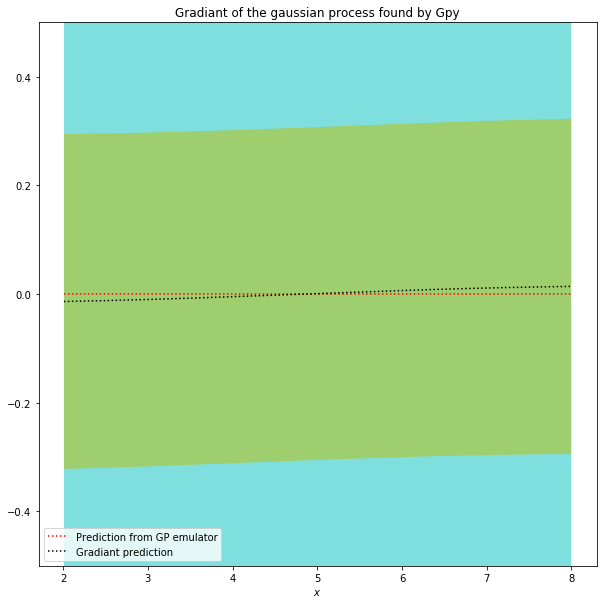

In [79]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
x_predict=x_eta
%matplotlib inline
plt.figure(figsize=(10,10))
#plt.plot(x_true,y_true, 'b-', label=r'$f(x) = x sin(x)$')
#plt.plot(x,y, 'r.', markersize=10, label='samples with noise')
plt.plot(x_predict, y_predict, 'r:', label='Prediction from GP emulator')
plt.fill_between(x_predict.flatten(),y_predict.flatten() - 1.9600 * sigma_predict.flatten(),y_predict.flatten() + 1.9600 * sigma_predict.flatten(), alpha=.5, fc='c', ec='None')
plt.xlabel('$x$')
#plt.plot(x_true,f_grad(x_true), 'g', label=r'$f(x) = xcos(x) + sin(x)$')
plt.plot(x_predict, mean_grad, 'k:', label='Gradiant prediction')
plt.fill_between(x_predict.flatten(),mean_grad.flatten() - 1.9600 * sigma_grad.flatten(),mean_grad.flatten() + 1.9600 * sigma_grad.flatten(), alpha=.5, fc='y', ec='None')
plt.title('Gradiant of the gaussian process found by Gpy')
plt.ylim(-0.5, 0.5)
plt.legend(loc='lower left')